In [1]:
import sys
import pdb
import json
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
# import seaborn as sns
# sns.set()

In [2]:
plt.title("test")
plt.close()

In [3]:
# !sshfs -p 3122 battleship:/groups/public/xxx/espnet /home/xxx/Projects/natst

In [4]:
sys.path.append('/home/xxx/Projects/natst')
import torch.nn.functional as F
from espnet.bin.st_trans import get_parser
from espnet.nets.pytorch_backend.e2e_st_transformer_encoder_seg import E2E as E2E_seg
from espnet.nets.pytorch_backend.e2e_st_transformer_encoder import E2E as E2E_st
from espnet.nets.pytorch_backend.e2e_st_transformer_encoder_buff import E2E as E2E_buf
from espnet.nets.pytorch_backend.transformer.attention import MultiHeadedAttention
from espnet.nets.pytorch_backend.ctc import CTC
from espnet.nets.pytorch_backend.nets_utils import to_device

In [5]:
"""
train_sp.en_lc.rm_pytorch_encoder_st_init_w_asr_correct_multitask_seg8 是multitask最強的

train_sp.en_lc.rm_pytorch_encoder_st_init_w_asr_correct 是沒有multitask的

exp/train_sp.en_lc.rm_pytorch_encoder_st_init_w_asr_correct_buff_attc
"""

'\ntrain_sp.en_lc.rm_pytorch_encoder_st_init_w_asr_correct_multitask_seg8 是multitask最強的\n\ntrain_sp.en_lc.rm_pytorch_encoder_st_init_w_asr_correct 是沒有multitask的\n\nexp/train_sp.en_lc.rm_pytorch_encoder_st_init_w_asr_correct_buff_attc\n'

In [6]:
espnet_dir = "/home/xxx/Projects/natst"
spm_model_path = f"{espnet_dir}/egs/fisher_callhome_spanish/st1/data/lang_1spm/train_sp.en_bpe1000_lc.rm.model"
nocuda = False

In [7]:
from utils import *

In [8]:
# load model
def load_model(exp, e2e_cls, model_name="model.val5.avg.best", extra_args={}, extra_opt=None):
    model_dir = f"{espnet_dir}/egs/fisher_callhome_spanish/st1/exp/{exp}/results"
    with open(model_dir + "/model.json", "r") as f:
        idim, odim, conf = json.load(f)
    model = e2e_cls(idim, odim, argparse.Namespace(**conf, **extra_args))
    if extra_opt is not None:
        extra_opt(model)
    if nocuda:
        model.load_state_dict(torch.load(f"{model_dir}/{model_name}", map_location=torch.device('cpu')))
    else:
        model.load_state_dict(torch.load(f"{model_dir}/{model_name}"))
    model.eval()
    return model, conf

# st model
st_model, conf = load_model(
    exp="train_sp.en_lc.rm_pytorch_encoder_st_init_w_asr_correct",
    e2e_cls=E2E_st,
)
# st_model, conf = load_model(
#     exp="train_sp.en_lc.rm_pytorch_encoder_st_init_w_asr_correct_buff_attc",
#     e2e_cls=E2E_buf,
#     model_name="model.last10.avg.best",
#     extra_opt=lambda x: x.encoder.add_buff()
# )
# st seg model
st_seg_model, conf = load_model(
    exp="train_sp.en_lc.rm_pytorch_encoder_st_init_w_asr_correct_multitask_seg8",
    e2e_cls=E2E_seg,
)

# load token dict
token_list = conf["char_list"]
# make <blank> -> ϕ
token_list[token_list.index("<blank>")] = " "

# load spm model
spm_model = SPMModel(spm_model_path, token_list)

In [9]:
# for i, (key, info) in enumerate(test_json.items()):
#     print(f"""{i}: {info["output"][0]["text"]} --- {info["output"][1]["text"]}""")

<ipython-input-25-c02bc242005c>:38: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


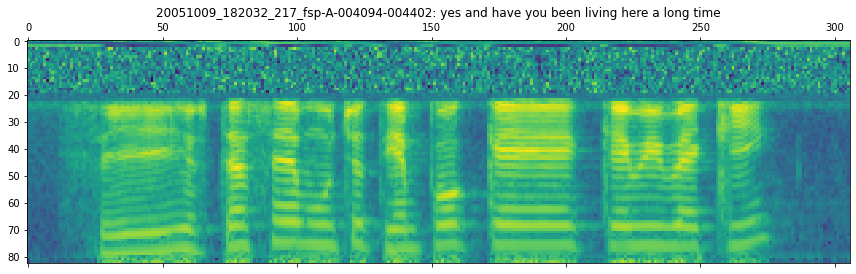

In [25]:
"""
197: because i was taught from childhood by the father --- porque a mi me enseñaron desde pequeña mi papá (very poor output)
235: and i looked at her and said --- y yo la miré y le dije (very poor output)

70: sometimes they do not greet you --- a veces no lo saludan a uno


162: oh do you know today &apos;s topic --- oh sabes el tema de hoy (good output/bad align)

348: you don &apos;t like --- no te gusta (good output!)
393: hablamos -> we talked (good alignment)
159: ("very" has interesting result)
12: has good reorder for "have" & "you" (but ctc model also did well)
32: "thing" (seg8 > ctc)
40: you
165: ,no? -> ,right? (very intresting...)

"""

import kaldiio
def translate_path(p):
#     return p.replace("/groups/public", "/home/xxx/Projects/public")
    return p.replace("/groups/public/xxx/espnet", "/home/xxx/Projects/natst")

# load 10-th speech/text in data.json
root = f"{espnet_dir}/egs/fisher_callhome_spanish/st1"
with open(root + "/dump/fisher_dev.en/deltafalse/data_bpe1000.lc.rm.json", "r") as f:
    test_json = json.load(f)["utts"]

key, info = list(test_json.items())[12]

# plot the speech feature
fbank_path = translate_path(info["input"][0]["feat"])
fbank = kaldiio.load_mat(fbank_path)

plt.matshow(fbank.T[::-1])
plt.title(key + ": " + info["output"][0]["text"])
plt.show()

In [26]:
from espnet.nets.pytorch_backend.transformer.subsampling import Conv2dSubsampling
def forward_buffer_encoder(self, xs, masks):
    """Encode input sequence.

    :param torch.Tensor xs: input tensor
    :param torch.Tensor masks: input mask
    :return: position embedded tensor and mask
    :rtype Tuple[torch.Tensor, torch.Tensor]:
    """
    extras = []
    if isinstance(self.embed, (Conv2dSubsampling, VGG2L)):
        xs, masks = self.embed(xs, masks)
    else:
        xs = self.embed(xs)
    if self.buff is not None: # mask: shape = (bs, t1, t2)
        # extent_mask = masks[:, :, :1].repeat(1, 1, self.num_buff) * 0
        if masks is None:
            masks = torch.ones(xs.shape[0], 1, xs.shape[1], dtype=torch.bool, device=xs.device)
        extent_mask = torch.zeros(masks.shape[0], masks.shape[1], self.num_buff, dtype=torch.bool, device=masks.device)
        try:
            masks = torch.cat([extent_mask, masks], dim=-1)
        except:
            import pdb
            pdb.set_trace()
        dual_masks = masks.clone().repeat(1, masks.shape[-1], 1).contiguous()
        dual_masks[:, :self.num_buff, :self.num_buff] = True
        xs = torch.cat([self.buff.unsqueeze(0).repeat(xs.shape[0], 1, 1), xs], dim=1)
    else:
        dual_masks = masks
        
    for i,layer in enumerate(self.encoders):
        xs.retain_grad()
        extras.append(xs)
        xs, dual_masks = layer(xs, dual_masks)

    if self.normalize_before:
        xs = self.after_norm(xs)
    xs = xs[:, self.num_buff:, :]
    masks = masks[:, :, self.num_buff:]
    return xs, masks, extras

In [27]:
# st & seg outputs
st_jacobian, st_ctc_output = find_multilayer_jacobian(
    st_model, fbank, modeltype="st")
# st_jacobian, st_ctc_output = find_multilayer_jacobian(
#     st_model, fbank, modeltype="st_buf", other_forward_encoder=forward_buffer_encoder)
st_seg_jacobian, st_seg_ctc_output, st_seg_asr_output = find_multilayer_jacobian(
    st_seg_model, fbank, modeltype="st_seg")

In [28]:
st_tgt = [token_list[y] for y in st_ctc_output[0]]
st_src = ["" for _ in range(st_jacobian.shape[1])]
st_seg_tgt = [token_list[y] for y in st_seg_ctc_output[0]]
st_seg_src = [token_list[x] for x in st_seg_asr_output[0]]

In [29]:
# plot_transition(
#     st_jacobian,
#     x_tokens=[st_src],
#     y_tokens=[st_tgt],
#     norm_fn=lambda a: sharp_norm(a, tau=0.3),
#     columns=2,
#     tick_size=16,
#     fig_size=(6,6),
#     mask=[y!=0 for y in st_ctc_output[0]],
#     yshift=64,
#     save="buffer.jpg"
# )


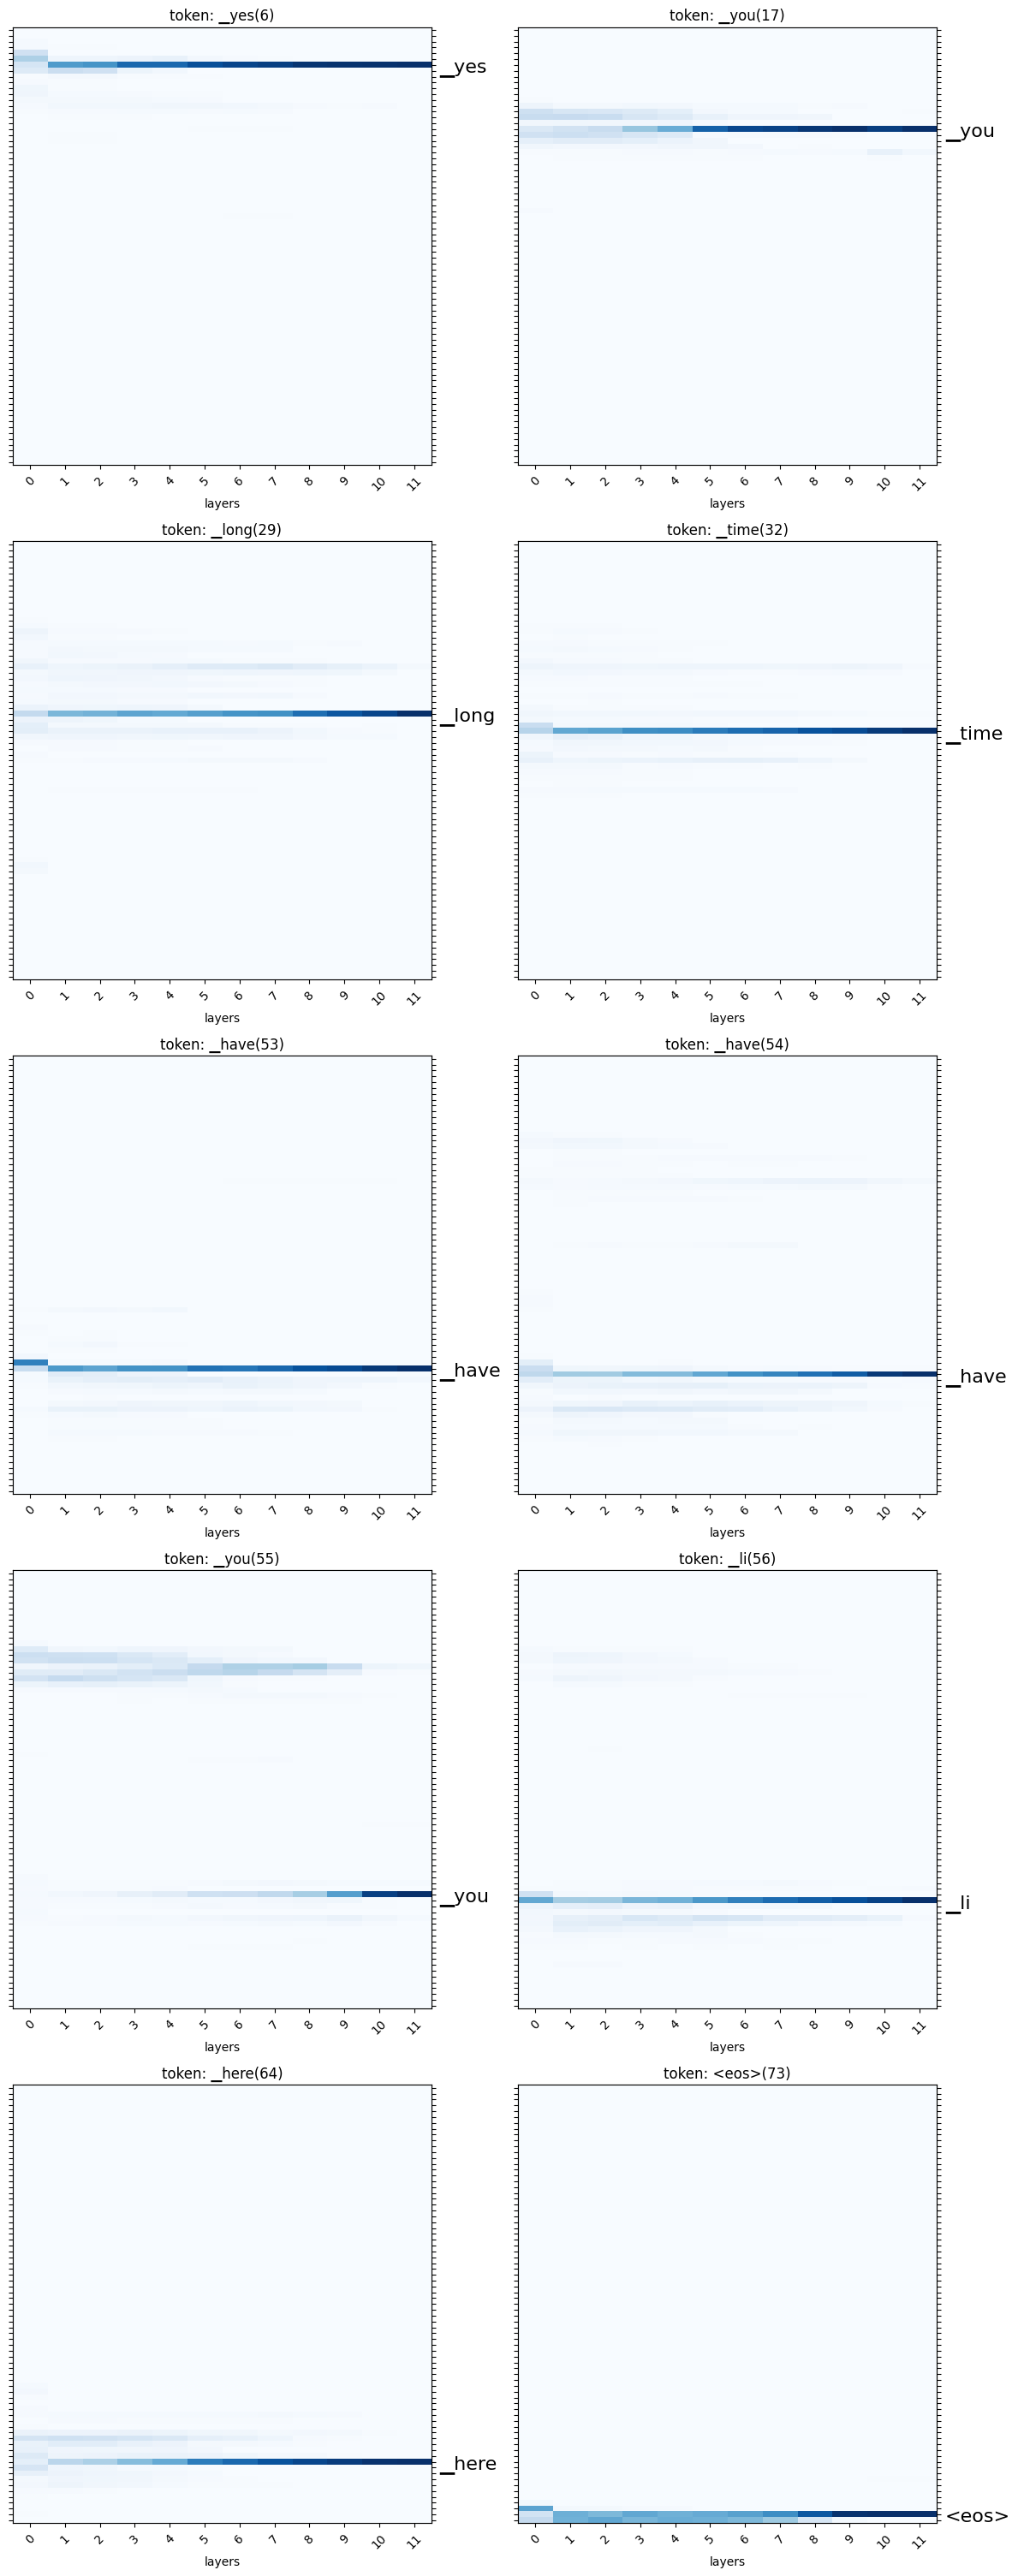

In [30]:
plot_transition(
    st_jacobian,
    x_tokens=[st_src],
    y_tokens=[st_tgt],
    norm_fn=lambda a: sharp_norm(a, tau=0.3),
    columns=2,
    tick_size=16,
    fig_size=(6,6),
    mask=[y!=0 for y in st_ctc_output[0]]
)

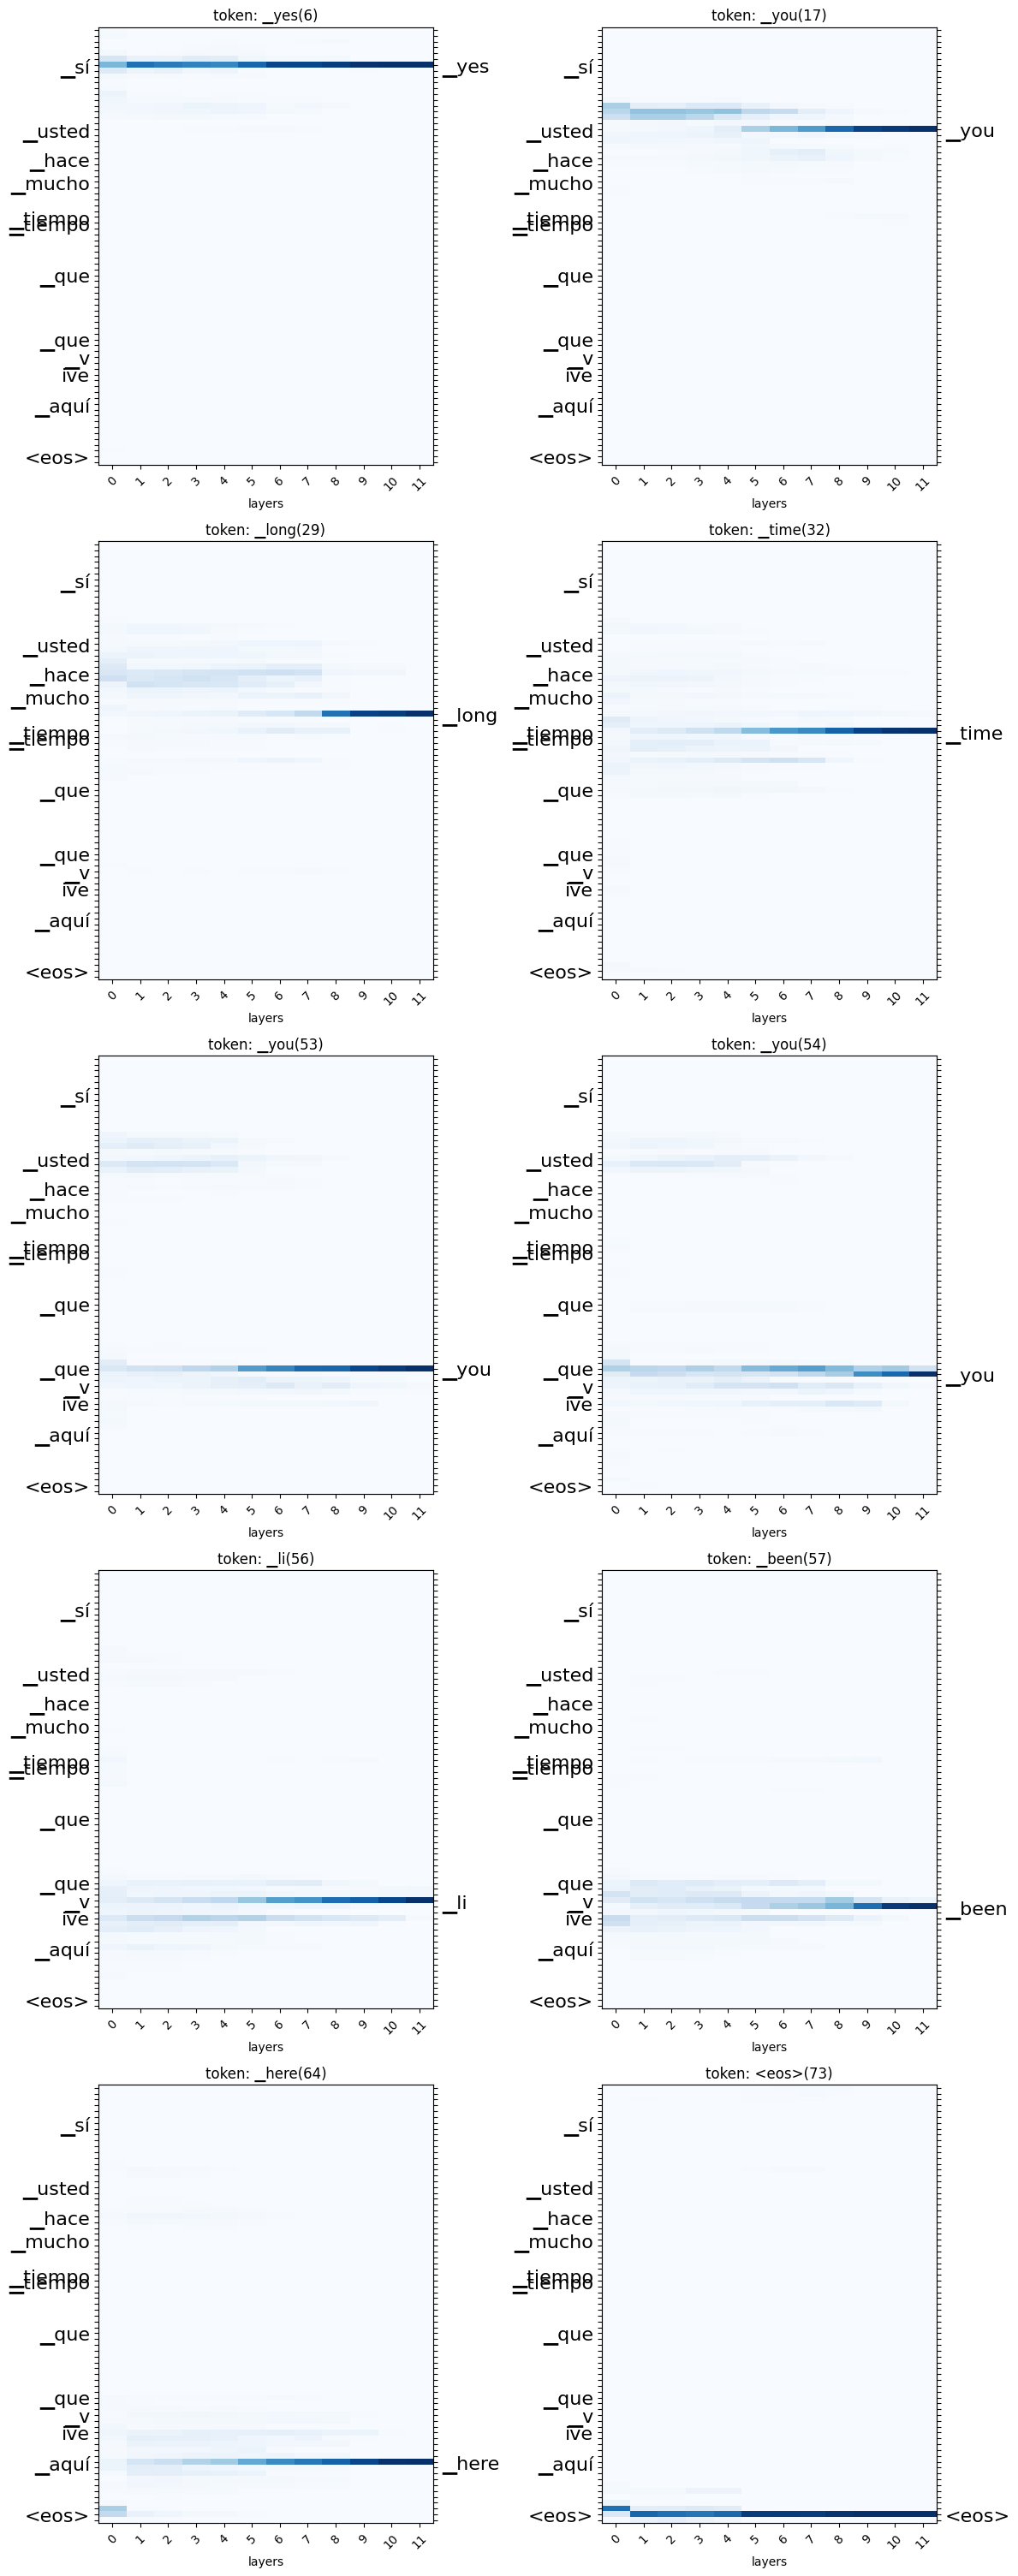

In [31]:
plot_transition(
    st_seg_jacobian,
    x_tokens=[st_seg_src],
    y_tokens=[st_seg_tgt],
    norm_fn=lambda a: sharp_norm(a, tau=0.3),
    columns=2,
    tick_size=16,
    fig_size=(6,6),
    mask=[y!=0 for y in st_seg_ctc_output[0]]
)

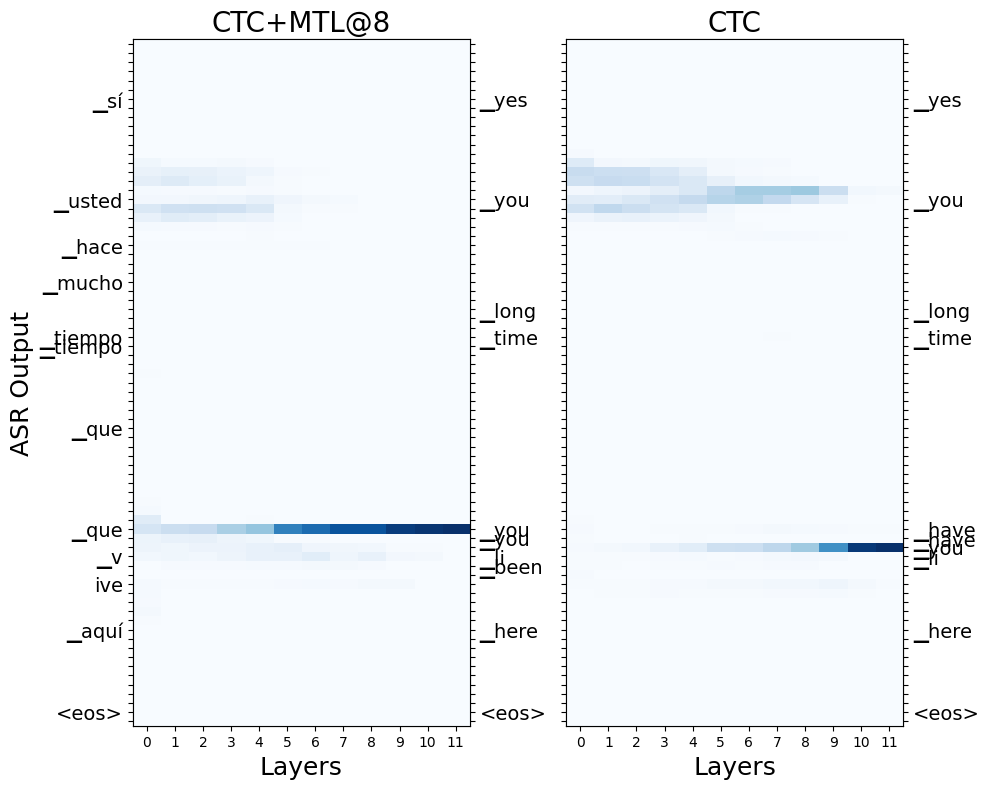

In [34]:
## Side by side
st_num = 55
st_seg_num = 53
tok_st = st_tgt[st_num]
tok_st_seg = st_seg_tgt[st_seg_num]
cmap = cm.Blues
fig_size = (5,8)
tick_size=14
label_size=18
title_size=20
start_index=0
end_index = len(st_seg_src) #.index("▁entonces") + 1
# while st_seg_src[end_index-1] in ['<eos>', ' ']:
#     end_index -= 1
# end_index = st_seg_tgt.index("▁that")+1

st_plot = sharp_norm(st_jacobian.transpose(0, 2)[st_num], tau=0.25)
st_seg_plot = sharp_norm(st_seg_jacobian.transpose(0, 2)[st_seg_num], tau=0.25)

st_plot = st_plot[start_index:end_index]
st_seg_plot = st_seg_plot[start_index:end_index]
st_seg_src = st_seg_src[start_index:end_index]
st_seg_tgt = st_seg_tgt[start_index:end_index]
st_tgt = st_tgt[start_index:end_index]

xlen, n_layers = st_plot.shape
fig = plt.figure(figsize=(fig_size[0]*2,fig_size[1]*1), dpi=100) 

# add seg on left
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(st_seg_plot, aspect='auto', cmap=cmap)
ax1.set_title("CTC+MTL@8", fontsize=title_size) # title

ax1.set_xlabel('Layers', fontsize=label_size)
ax1.set_xticks(range(n_layers))
ax1.set_ylabel('ASR Output', fontsize=label_size)
ax1.set_yticks(range(xlen)) 
ax1.set_yticklabels(st_seg_src, fontsize=tick_size)
# for tick in ax1.get_yticklabels(): # diagonal xtick
#     tick.set_rotation(45)

ax1_r = ax1.twinx()
ax1_r.imshow(st_seg_plot, aspect='auto', cmap=cmap)
ax1_r.set_yticks(range(xlen)) 
right_labels1 = [ st_seg_tgt[i] for i in range(xlen)]#[ st_seg_tgt[i] if i==st_seg_num else "" for i in range(xlen)]
ax1_r.set_yticklabels(right_labels1, fontsize=tick_size)

# add st on right
ax2 = fig.add_subplot(1, 2, 2, sharey=ax1_r)
ax2.imshow(st_plot, aspect='auto', cmap=cmap)
ax2.set_title("CTC", fontsize=title_size) # title

ax2.set_xlabel('Layers', fontsize=label_size)
ax2.set_xticks(range(n_layers))
# plt.setp(ax2.get_yticklabels(), visible=False)

ax2_r = ax2.twinx()
ax2_r.imshow(st_plot, aspect='auto', cmap=cmap)
ax2_r.set_yticks(range(xlen)) 
right_labels2 = [ st_tgt[i] for i in range(xlen)] #[ st_tgt[i] if i==st_num else "" for i in range(xlen)]
ax2_r.set_yticklabels(right_labels2, fontsize=tick_size)

plt.setp(ax2.get_yticklabels(), visible=False)

fig.tight_layout()

In [35]:
fig.savefig(f"{tok_st_seg}2.jpg")

In [ ]:
# tok_st = "▁thing"
# tok_st_seg = "▁thing"
# st_num = st_tgt.index(tok_st)
# st_seg_num = st_seg_tgt.index(tok_st_seg)

In [ ]:
"""
we use gradient norm of target logits w.r.t latent representation of each position of each layer...

left vertical axis is annotated with the asr output of multitask model.
right vertical axis is marked with the token's position.
the horizontal axis represents each layer of the model


"""

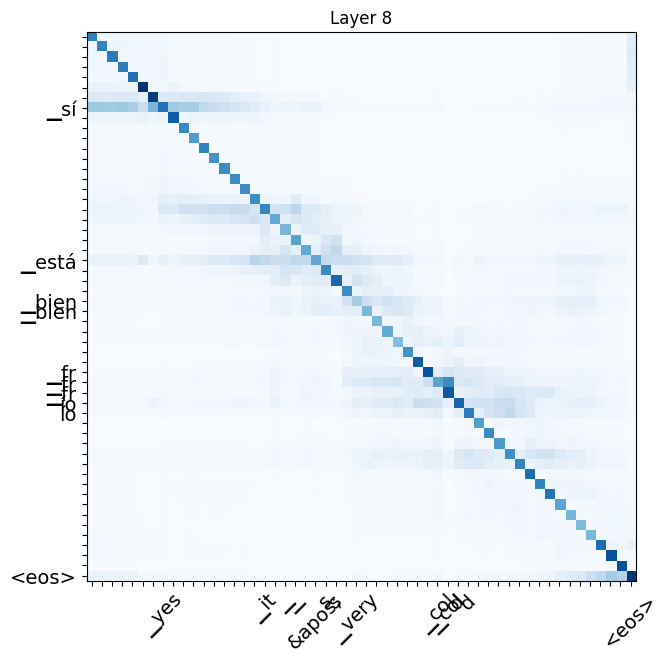

In [18]:
plot_align(
    st_seg_jacobian[7:8],
    titles=["Layer 8"],
    x_tokens=[st_seg_src],
    y_tokens=[st_seg_tgt],
    norm_fn=lambda a: sharp_norm(a, tau=0.7),
    columns=1,
    fig_size = (8,8),
    tick_size=14,
    save=f"frio.jpg",
)

In [ ]:
# collapse = False
# collapsed_jacobians = []
# for J in mjacobian:
#     if collapse:
#         collapsed_output, collapsed_J = ctc_collapse(ctc_output, J, reduction='sum')
#     else:
#         collapsed_output, collapsed_J = ctc_output[0], J
#     collapsed_jacobians.append(collapsed_J)
    
# tgt = [token_list[y] for y in collapsed_output]
# src = ["" for _ in tgt]
# if modeltype == "st_seg":
#     src = [token_list[x] for x in asr_output[0]]
# print(spm_model.decode(collapsed_output))

# plot_align(
#     collapsed_jacobians,
#     x_tokens=[src],
#     y_tokens=[tgt],
#     norm_fn=lambda a: sharp_norm(a, tau=0.7),
#     columns=2,
#     tick_size=16,
#     fig_size=(8,8)
# )

In [ ]:
def _decode(i):
    key, info = list(test_json.items())[i]
    fbank_path = translate_path(info["input"][0]["feat"])
    fbank = kaldiio.load_mat(fbank_path)
    mjacobian, ctc_output = find_multilayer_jacobian(model, fbank, modeltype=modeltype)
    for J in mjacobian:
        collapsed_output, collapsed_J = ctc_collapse(ctc_output, J, reduction='sum')
    print(spm_model.decode(collapsed_output))

# for i, (key, info) in enumerate(test_json.items()):
#     print(f"""{i}: {info["output"][0]["text"]} --- {info["output"][1]["text"]}""")
#     _decode(i)

In [ ]:
"/groups/xxx/data/kaldi_fisher_callhome/gen_align.py"